#Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, datasets
print("TF version:", tf.__version__)

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import seaborn as sns
import warnings 
import os
import cv2 
from tqdm import tqdm
from fastai import *
from fastai.vision import *
import os, shutil, pathlib
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.layers import  Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from tensorflow.keras import layers,utils


%matplotlib inline

TF version: 2.12.0


#Function setup

In [ ]:
def display_predictions(model, dataset, class_names):
    plt.figure(figsize=(10, 5))
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        predictions = model.predict(images)
        for i in range(10):
            img_array = images[i]
            img_array /= 255.0
            plt.subplot(2, 5, i+1)
            plt.imshow(img_array)
            plt.axis('off')
            predicted_label = np.argmax(predictions[i])
            actual_label = class_names[labels[i]]
            predicted_class = class_names[predicted_label]
            if predicted_label == labels[i]:
                color = 'green'
            else:
                color = 'red'
            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_class}", color=color,fontsize=10)
    plt.show()


In [ ]:
def display_images(train_ds, num_images):
    # Get the first n images and labels from the training dataset
    images, labels = next(iter(train_ds.take(1)))
    images = images[:num_images].numpy()
    labels = labels[:num_images].numpy()

    # Get the label names from the dataset
    class_names = train_ds.class_names

    # Display the images and labels
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
tf.get_logger().setLevel('ERROR')

def display_augmented_images(dataset,aug_method):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        plt.figure(figsize=(10,8))
        plt.subplot(3, 4, 5)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
        print(f"Shape of Batch: {images.shape}")

        for i in range(9):
            augmented_images = aug_method(images)
            ax = plt.subplot(3, 4, int(i/3)*4 + 2 + (i % 3))
            plt.imshow(augmented_images[0].numpy().astype("uint8")) 
            plt.axis("off")
            plt.tight_layout()
        return plt

   



In [ ]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    plt.figure(figsize=(10,3))
    for i, (tgt, val_tgt) in enumerate(zip(tgts, vtgts)):
      plt.subplot(1,2, i+1)
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      #plt.ylabel(ylab)
      plt.legend()
      plt.title(f"Training and validation {tgt}")

#Kaggle setup

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anulitha","key":"299c6b7f4b0e98ef0ef221afde0f7a49"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Brain Tumor Dataset

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force

 90% 133M/149M [00:01<00:00, 99.4MB/s]
100% 149M/149M [00:01<00:00, 111MB/s] 


In [ ]:
!unzip /content/brain-tumor-mri-dataset

##Loading the dataset

In [ ]:
# TODO: load data
from keras.utils import image_dataset_from_directory
 
resnet_train = image_dataset_from_directory(
    "/content/Training",
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset = 'training',
    seed = 42,

)

resnet_valid = image_dataset_from_directory(
    "/content/Training",
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset = 'validation',
    seed = 42
)


resnet_test = image_dataset_from_directory(
    "/content/Testing",
    image_size = (224,224),
    batch_size=32,
)




Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
for data_batch, labels_batch in resnet_train:
    print("resnet train-data batch shape:", data_batch.shape)
    print("resnet train-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_valid:
    print("resnet valid-data batch shape:", data_batch.shape)
    print("resnet valid-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_test:
    print("resnet test-data batch shape:", data_batch.shape)
    print("resnet test-labels batch shape:", labels_batch.shape)
    break

resnet train-data batch shape: (32, 224, 224, 3)
resnet train-labels batch shape: (32,)
resnet valid-data batch shape: (32, 224, 224, 3)
resnet valid-labels batch shape: (32,)
resnet test-data batch shape: (32, 224, 224, 3)
resnet test-labels batch shape: (32,)


#Brain Tumor - Images

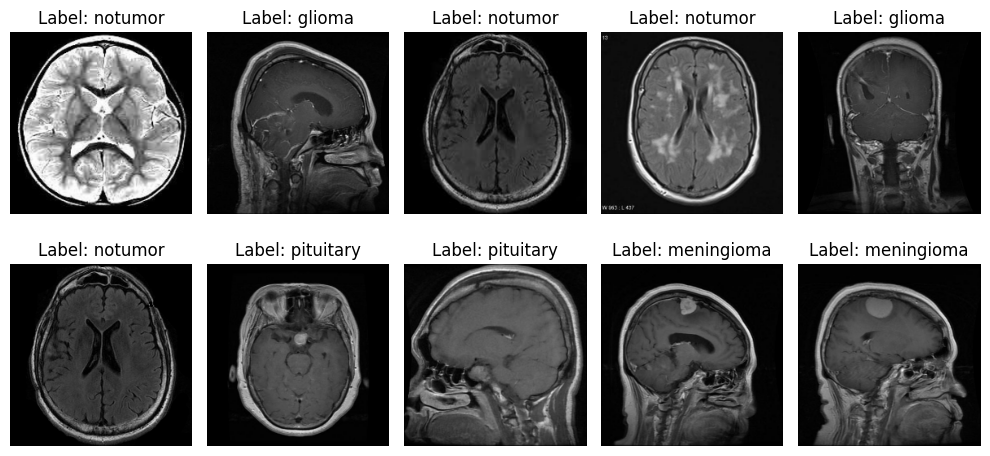

In [ ]:
display_images(resnet_train,10)

#Image Augmentation

In [ ]:
resnet_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(10),
        layers.RandomWidth(0.05),
        layers.RandomHeight(0.05)
    ]
)

#Brain Tumor - Augmented Images

Shape of Batch: (32, 224, 224, 3)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

<Figure size 1000x1000 with 0 Axes>

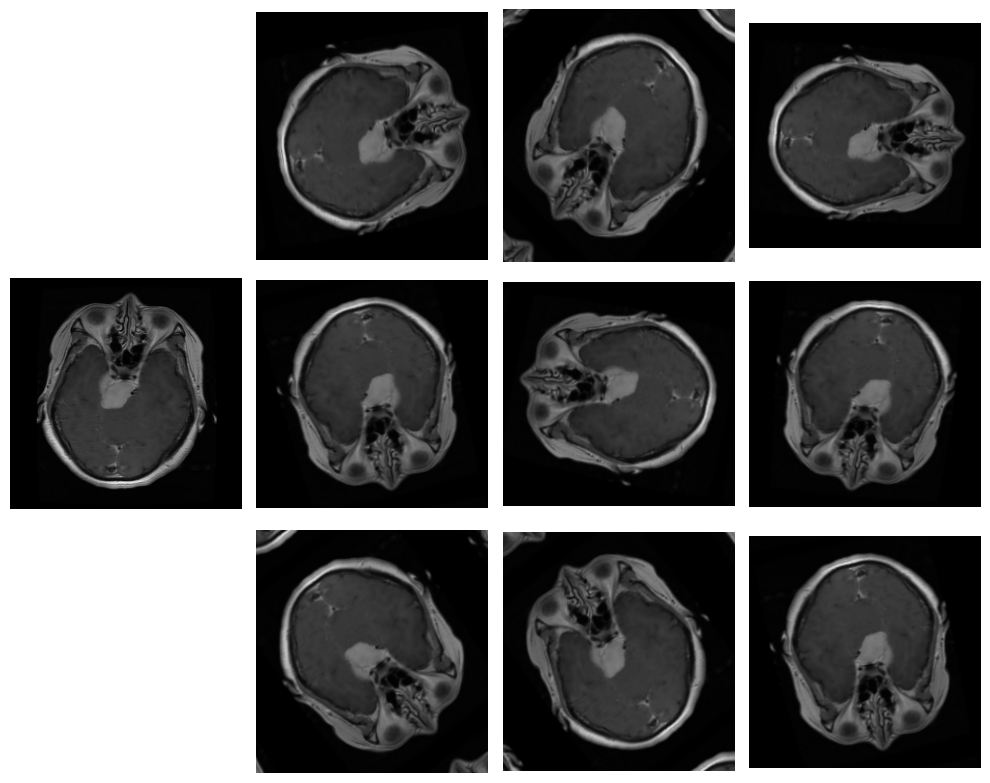

In [ ]:
display_augmented_images(resnet_train,resnet_data_augmentation)

#Loading RESNET-50 

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

#Resnet50 - Brain MRI - Trial 1

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = resnet_data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
outputs = resnet(x)
x = layers.GlobalAveragePooling2D()(outputs)
x = layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

resnet.trainable = False

# Define the model input and output
model2 = keras.Model(inputs=inputs, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem_7   (None, None, None, 3)    0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, None, None, 3)    0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0  

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

checkpoint = ModelCheckpoint('Resnet_FirstModel.keras', monitor='val_loss', mode='min')

callbacks = [checkpoint]

history = model2.fit(resnet_train,validation_data = resnet_valid, epochs = EPOCHS,callbacks = callbacks)
                     
                     

Epoch 1/50
143/143 [==============================] - 64s 387ms/step - loss: 0.7025 - accuracy: 0.7737 - val_loss: 0.9297 - val_accuracy: 0.7653
Epoch 2/50
143/143 [==============================] - 34s 234ms/step - loss: 0.4547 - accuracy: 0.8477 - val_loss: 0.4681 - val_accuracy: 0.8520
Epoch 3/50
143/143 [==============================] - 31s 214ms/step - loss: 0.3866 - accuracy: 0.8637 - val_loss: 0.4951 - val_accuracy: 0.8345
Epoch 4/50
143/143 [==============================] - 28s 195ms/step - loss: 0.3320 - accuracy: 0.8781 - val_loss: 0.5325 - val_accuracy: 0.8424
Epoch 5/50
143/143 [==============================] - 28s 196ms/step - loss: 0.3186 - accuracy: 0.8840 - val_loss: 0.4004 - val_accuracy: 0.8722
Epoch 6/50
143/143 [==============================] - 27s 184ms/step - loss: 0.2854 - accuracy: 0.8926 - val_loss: 0.4261 - val_accuracy: 0.8389
Epoch 7/50
143/143 [==============================] - 27s 184ms/step - loss: 0.2929 - accuracy: 0.8906 - val_loss: 0.4038 - val_ac

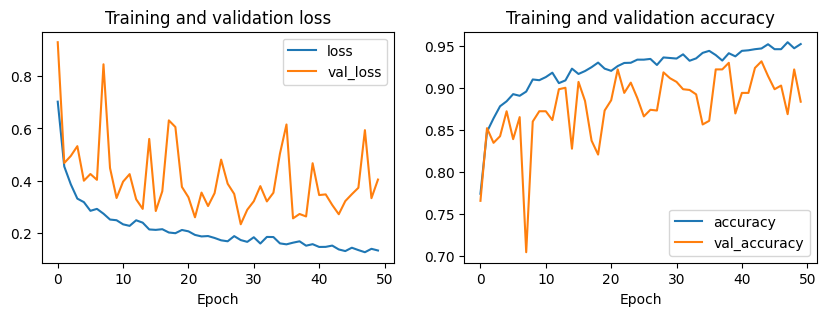

In [ ]:
plot_learning(history)

In [ ]:
model2.evaluate(resnet_test)

41/41 [==============================] - 5s 101ms/step - loss: 0.2999 - accuracy: 0.9077


[0.2998672425746918, 0.9077040553092957]

#Resnet50 - Global Model

In [ ]:
model3 = resnet.output
model3 = resnet_data_augmentation(model3)
model3 = GlobalAveragePooling2D()(model3)
model3 = Dropout(0.4)(model3)
model3 = Dense(4, activation="softmax")(model3)
model3 = keras.Model(inputs= resnet.input, outputs= model3)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(optimizer=adam, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()


In [ ]:
BATCH_SIZE = 32
EPOCHS = 50

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,checkpoint]

history = model3.fit(resnet_train,validation_data = resnet_valid, epochs = EPOCHS,callbacks = callbacks)
                     
                     

Epoch 1/50
143/143 [==============================] - 49s 342ms/step - loss: 0.0232 - accuracy: 0.9939 - val_loss: 0.1260 - val_accuracy: 0.9597 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - 51s 355ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.1383 - val_accuracy: 0.9658 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - 49s 344ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.1125 - val_accuracy: 0.9702 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - 50s 347ms/step - loss: 0.0175 - accuracy: 0.9952 - val_loss: 0.3398 - val_accuracy: 0.9089 - lr: 1.0000e-04
Epoch 5/50
143/143 [==============================] - 51s 351ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.1375 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 6/50
143/143 [==============================] - 50s 350ms/step - loss: 0.0178 - accuracy: 0.9947 - val_loss: 0.1902 - val_accuracy: 0.9606 - lr: 1.0000e-04
Epoch 7/50
143/143 [========

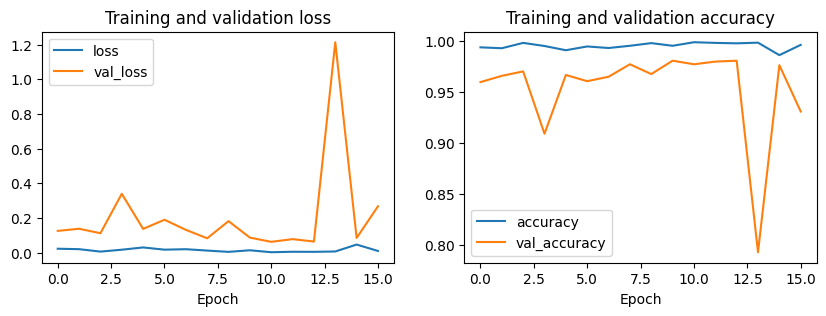

In [ ]:
plot_learning(history)

#Evaluation and Prediction

In [ ]:
model3.evaluate(resnet_test)

41/41 [==============================] - 5s 118ms/step - loss: 0.0645 - accuracy: 0.9809


[0.06454216688871384, 0.9809305667877197]

In [ ]:
class_names = ['notumor','meningioma','glioma','pituitary']

1/1 [==============================] - 0s 34ms/step


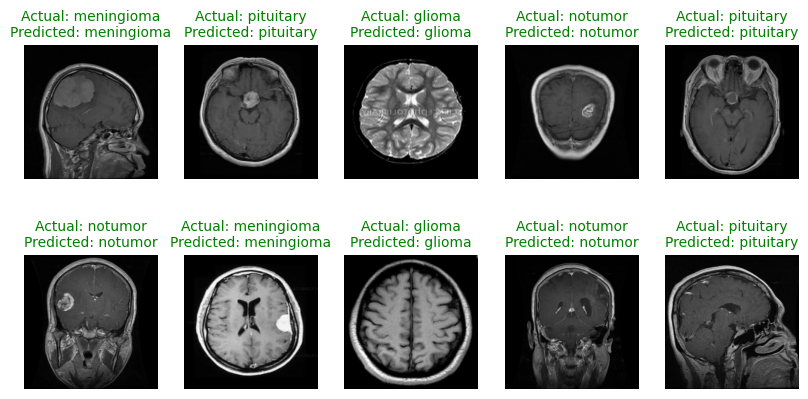

In [ ]:
display_predictions(model3, resnet_test, class_names)

#Leukemia Dataset

In [ ]:
!kaggle datasets download -d abeerelmorshedy/leukemia

 97% 452M/466M [00:05<00:00, 133MB/s]
100% 466M/466M [00:05<00:00, 85.8MB/s]


In [ ]:
!unzip -q /content/leukemia.zip -d /content/leukemia

In [ ]:
!ls -l /content/leukemia/training

total 252
drwxr-xr-x 2 root root 147456 May  2 17:15 all
drwxr-xr-x 2 root root 106496 May  2 17:15 hem


#Loading the dataset

In [ ]:
from keras.utils import image_dataset_from_directory
 
resnet_train_leu = image_dataset_from_directory(
    "/content/leukemia/training",
    batch_size=32,
    image_size=(224,224),
    seed = 42,
    
)

resnet_valid_leu = image_dataset_from_directory(
    "/content/leukemia/validation",
    batch_size=32,
    image_size=(224,224),
    seed = 42
)


resnet_test_leu = image_dataset_from_directory(
    "/content/leukemia/validation",
    image_size = (224,224),
    batch_size=32
)





Found 6090 files belonging to 2 classes.
Found 1260 files belonging to 2 classes.
Found 1260 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in resnet_train_leu:
    print("resnet train-data batch shape:", data_batch.shape)
    print("resnet train-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_valid_leu:
    print("resnet valid-data batch shape:", data_batch.shape)
    print("resnet valid-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_test_leu:
    print("resnet test-data batch shape:", data_batch.shape)
    print("resnet test-labels batch shape:", labels_batch.shape)
    break

resnet train-data batch shape: (32, 224, 224, 3)
resnet train-labels batch shape: (32, 1)
resnet valid-data batch shape: (32, 224, 224, 3)
resnet valid-labels batch shape: (32, 1)
resnet test-data batch shape: (32, 224, 224, 3)
resnet test-labels batch shape: (32, 1)


##Leukemia - Images

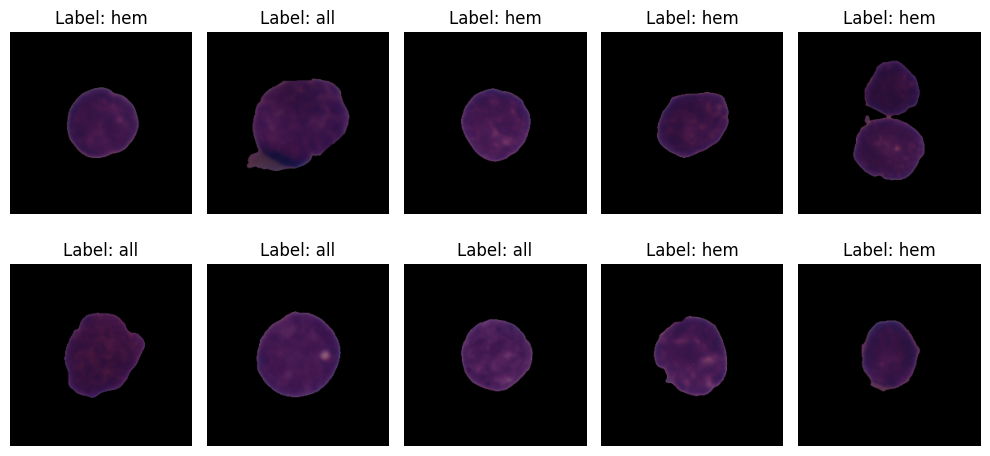

In [ ]:
display_images(resnet_train_leu,10)

#Leukemia - Augmented Images

Shape of Batch: (32, 224, 224, 3)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

<Figure size 1000x1000 with 0 Axes>

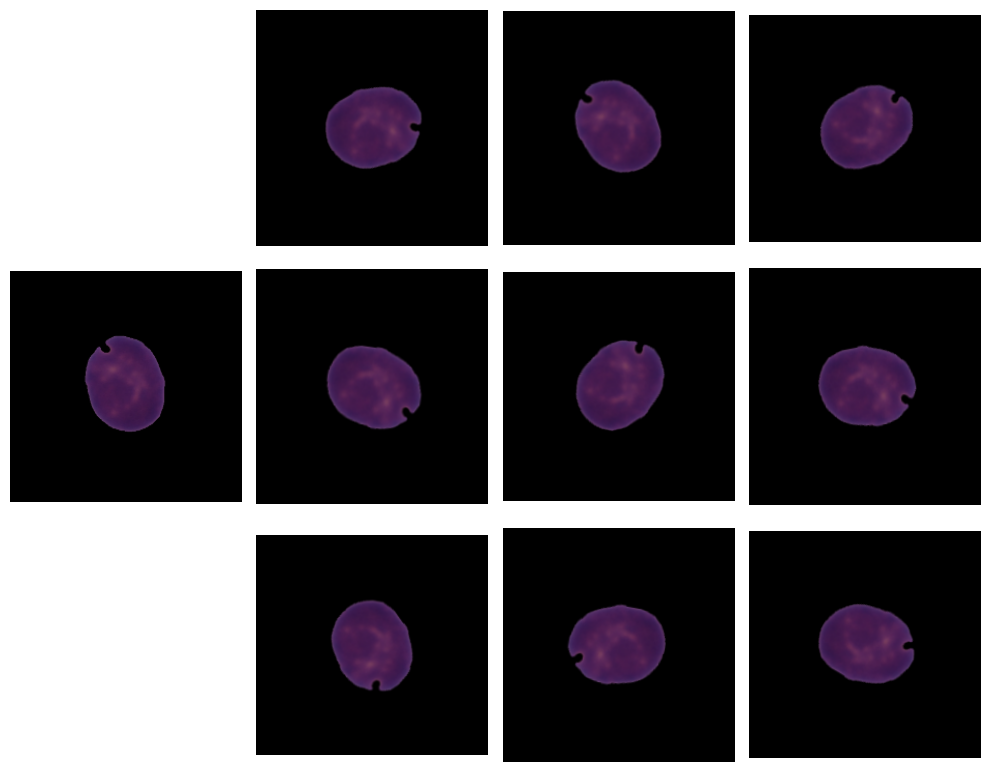

In [ ]:
display_augmented_images(resnet_train_leu,resnet_data_augmentation)

#Resnet50 - Leukemia - Trial 1 Model

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = resnet_data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
outputs = resnet(x)
x = layers.GlobalAveragePooling2D()(outputs)
x = layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

resnet.trainable = False

# Define the model input and output
model2 = keras.Model(inputs=inputs, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

checkpoint = ModelCheckpoint('Resnet_FirstModel_leu.keras', monitor='val_loss', mode='min')

callbacks = [checkpoint]

history = model2.fit(resnet_train_leu,validation_data = resnet_valid_leu, epochs = EPOCHS,callbacks = callbacks)
                     
                     

Epoch 1/50
191/191 [==============================] - 39s 166ms/step - loss: 0.6271 - accuracy: 0.7544 - val_loss: 2.1060 - val_accuracy: 0.5825
Epoch 2/50
191/191 [==============================] - 31s 158ms/step - loss: 0.4919 - accuracy: 0.7936 - val_loss: 1.0978 - val_accuracy: 0.5119
Epoch 3/50
191/191 [==============================] - 32s 165ms/step - loss: 0.4297 - accuracy: 0.8141 - val_loss: 0.7660 - val_accuracy: 0.6071
Epoch 4/50
191/191 [==============================] - 32s 163ms/step - loss: 0.4079 - accuracy: 0.8291 - val_loss: 0.6981 - val_accuracy: 0.6325
Epoch 5/50
191/191 [==============================] - 31s 156ms/step - loss: 0.4069 - accuracy: 0.8286 - val_loss: 0.7926 - val_accuracy: 0.6603
Epoch 6/50
191/191 [==============================] - 36s 184ms/step - loss: 0.3837 - accuracy: 0.8429 - val_loss: 0.8116 - val_accuracy: 0.6460
Epoch 7/50
191/191 [==============================] - 31s 158ms/step - loss: 0.3713 - accuracy: 0.8415 - val_loss: 1.1890 - val_ac

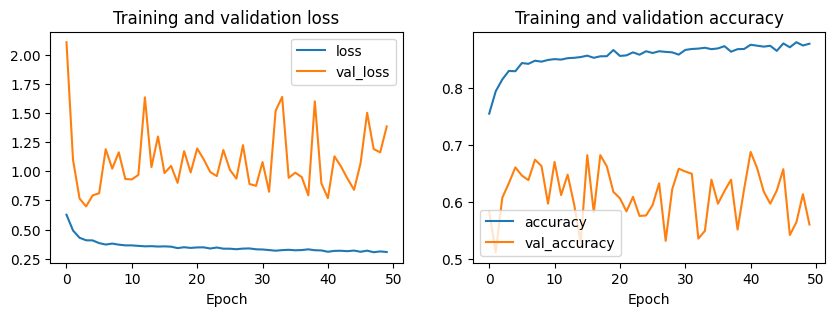

In [ ]:
plot_learning(history)

In [ ]:
model2.evaluate(resnet_test_leu)

40/40 [==============================] - 13s 105ms/step - loss: 1.3481 - accuracy: 0.5556


[1.348095178604126, 0.5555555820465088]

#Resnet50 - Leukemia - Model

In [ ]:
model = resnet.output
model = resnet_data_augmentation(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(2, activation="softmax")(model)
model = keras.Model(inputs= resnet.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
BATCH_SIZE = 64
EPOCHS = 25

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

checkpoint = ModelCheckpoint('Leukemia.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,checkpoint]

history = model.fit(resnet_train_leu,validation_data = resnet_valid_leu, epochs = EPOCHS,callbacks = callbacks)
                     
                     

Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8785
Epoch 1: val_loss improved from inf to 2.05721, saving model to Leukemia.keras
191/191 [==============================] - 123s 361ms/step - loss: 0.2968 - accuracy: 0.8785 - val_loss: 2.0572 - val_accuracy: 0.6556 - lr: 1.0000e-04
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9499
Epoch 2: val_loss improved from 2.05721 to 0.82147, saving model to Leukemia.keras
191/191 [==============================] - 67s 346ms/step - loss: 0.1243 - accuracy: 0.9499 - val_loss: 0.8215 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9649
Epoch 3: val_loss did not improve from 0.82147
191/191 [==============================] - 66s 344ms/step - loss: 0.0907 - accuracy: 0.9649 - val_loss: 1.4489 - val_accuracy: 0.7190 - lr: 1.0000e-04
Epoch 4/25
191/191 [=============================

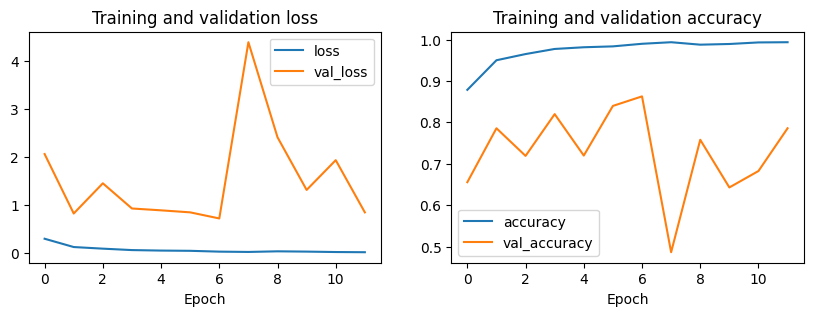

In [ ]:
plot_learning(history)

#Evaluation and Prediction

In [ ]:
model.evaluate(resnet_test_leu)

40/40 [==============================] - 5s 98ms/step - loss: 0.7184 - accuracy: 0.8627


[0.7184396386146545, 0.8626984357833862]

In [ ]:
class_names = ['all','hem']

1/1 [==============================] - 1s 982ms/step


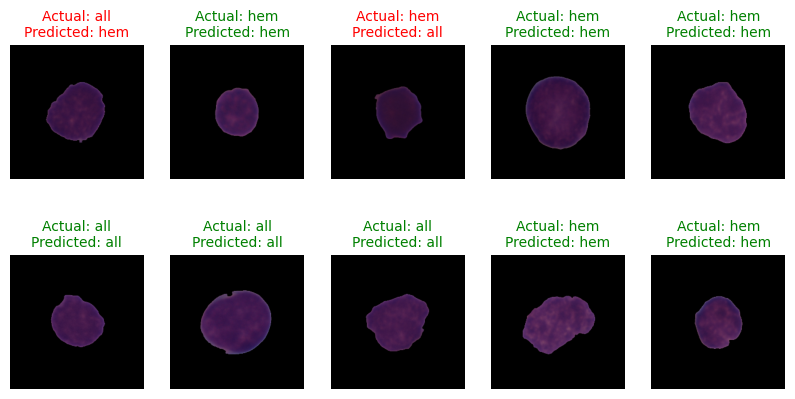

In [ ]:
display_predictions(model, resnet_test_leu, class_names)

#Chest MRI Dataset

In [ ]:
!kaggle datasets download -d artyomkolas/3-kinds-of-pneumonia

 99% 3.47G/3.49G [00:35<00:00, 135MB/s]
100% 3.49G/3.49G [00:35<00:00, 104MB/s]


In [ ]:
!unzip /content/3-kinds-of-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: Curated X-Ray Dataset/Normal/Normal (691).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (692).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (693).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (694).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (695).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (696).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (697).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (698).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (699).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (7).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (70).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (700).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (701).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (702).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (703).jpg  
  inflating: Curated X-Ray Dataset/No

#Loading the dataset

In [ ]:
!mv '/content/Curated X-Ray Dataset' /content/Curated_X-Ray_Dataset

In [ ]:
!ls -l /content/Curated_X-Ray_Dataset

total 472
drwxr-xr-x 2 root root  65536 May  2 18:51 COVID-19
drwxr-xr-x 2 root root 126976 May  2 18:51 Normal
drwxr-xr-x 2 root root 188416 May  2 18:52 Pneumonia-Bacterial
drwxr-xr-x 2 root root  86016 May  2 18:52 Pneumonia-Viral


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Curated_X-Ray_Dataset', output='/content/Curated_X-Ray_Dataset/split', seed=42, ratio=(0.5, 0.2, 0.3))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 9208 files [00:31, 292.19 files/s]


In [ ]:
!ls -l /content/Curated_X-Ray_Dataset/split/*

/content/Curated_X-Ray_Dataset/split/test:
total 144
drwxr-xr-x 2 root root 20480 May  2 18:52 COVID-19
drwxr-xr-x 2 root root 36864 May  2 18:52 Normal
drwxr-xr-x 2 root root 57344 May  2 18:52 Pneumonia-Bacterial
drwxr-xr-x 2 root root 32768 May  2 18:52 Pneumonia-Viral

/content/Curated_X-Ray_Dataset/split/train:
total 236
drwxr-xr-x 2 root root 32768 May  2 18:52 COVID-19
drwxr-xr-x 2 root root 69632 May  2 18:52 Normal
drwxr-xr-x 2 root root 90112 May  2 18:52 Pneumonia-Bacterial
drwxr-xr-x 2 root root 49152 May  2 18:52 Pneumonia-Viral

/content/Curated_X-Ray_Dataset/split/val:
total 100
drwxr-xr-x 2 root root 12288 May  2 18:52 COVID-19
drwxr-xr-x 2 root root 32768 May  2 18:52 Normal
drwxr-xr-x 2 root root 36864 May  2 18:52 Pneumonia-Bacterial
drwxr-xr-x 2 root root 20480 May  2 18:52 Pneumonia-Viral


In [ ]:
class_names = ['COVID-19','Pneumonia-Bacterial','Pneumonia-Viral','Normal']

In [ ]:
# Use image_dataset_from_directory to create the train set
resnet_train_xray = tf.keras.utils.image_dataset_from_directory(
    '/content/Curated_X-Ray_Dataset/split/train',
    seed=42,
    image_size=(224,224),
    batch_size=32
)

# Use image_dataset_from_directory to create the validation set
resnet_valid_xray = tf.keras.utils.image_dataset_from_directory(
    '/content/Curated_X-Ray_Dataset/split/val',
    seed=42,
    image_size=(224,224),
    batch_size=32
)

# Use image_dataset_from_directory to create the test set
resnet_test_xray = tf.keras.utils.image_dataset_from_directory(
    '/content/Curated_X-Ray_Dataset/split/test',
    seed=42,
    image_size=(224,224),
    batch_size=32
)


Found 4603 files belonging to 4 classes.
Found 1841 files belonging to 4 classes.
Found 2764 files belonging to 4 classes.


In [ ]:
for data_batch, labels_batch in resnet_train_xray:
    print("resnet train-data batch shape:", data_batch.shape)
    print("resnet train-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_valid_xray:
    print("resnet valid-data batch shape:", data_batch.shape)
    print("resnet valid-labels batch shape:", labels_batch.shape)
    break

for data_batch, labels_batch in resnet_test_xray:
    print("resnet test-data batch shape:", data_batch.shape)
    print("resnet test-labels batch shape:", labels_batch.shape)
    break

resnet train-data batch shape: (32, 224, 224, 3)
resnet train-labels batch shape: (32,)
resnet valid-data batch shape: (32, 224, 224, 3)
resnet valid-labels batch shape: (32,)
resnet test-data batch shape: (32, 224, 224, 3)
resnet test-labels batch shape: (32,)


#X-ray - Images

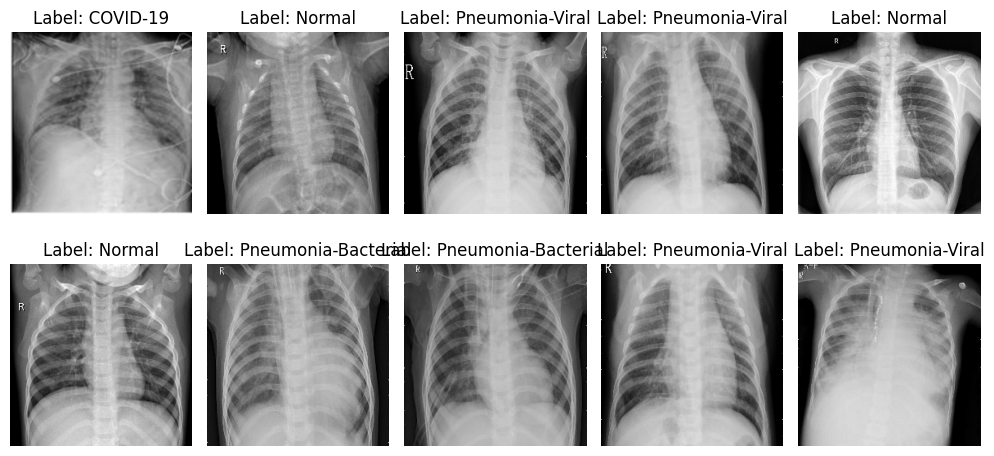

In [ ]:
display_images(resnet_train_xray,10)

#Chest XRay - Augmented images

Shape of Batch: (32, 224, 224, 3)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

<Figure size 1000x1000 with 0 Axes>

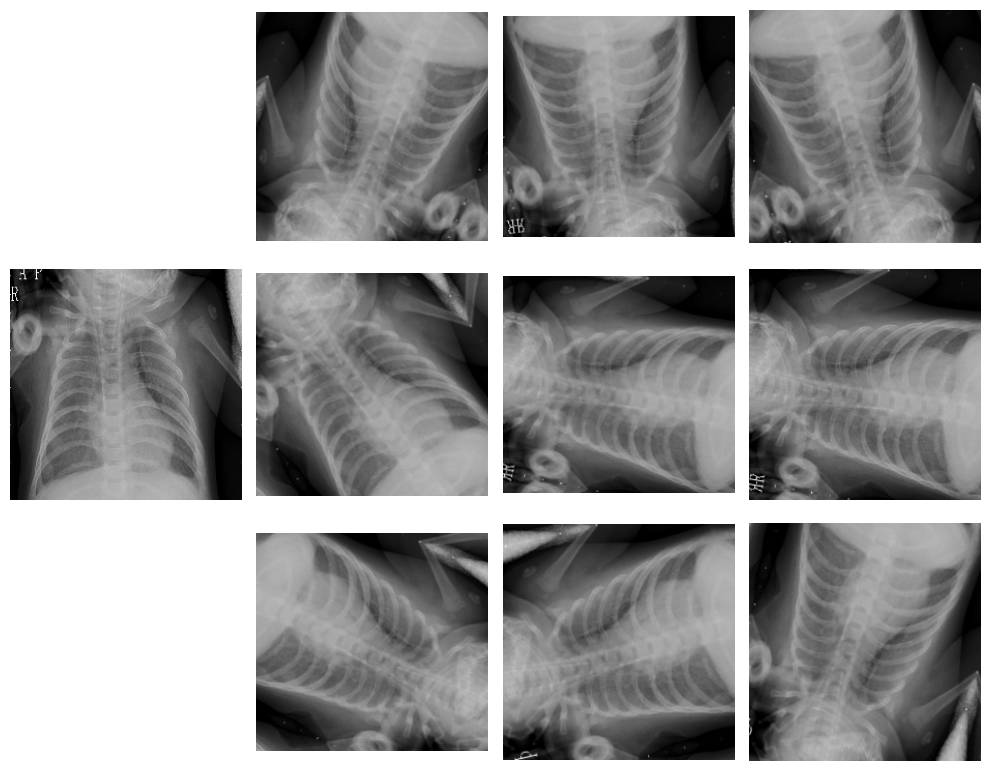

In [ ]:
display_augmented_images(resnet_train_xray,resnet_data_augmentation)

#Resnet50 - Chest Xray - Trial 1 Model

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

checkpoint = ModelCheckpoint('Resnet_FirstModel_Xray.keras', monitor='val_loss', mode='min')

callbacks = [checkpoint]

history = model2.fit(resnet_train_xray,validation_data = resnet_valid_xray, epochs = EPOCHS,callbacks = callbacks)
                     
                     

Epoch 1/50
144/144 [==============================] - 84s 465ms/step - loss: 0.8376 - accuracy: 0.7078 - val_loss: 1.1275 - val_accuracy: 0.7431
Epoch 2/50
144/144 [==============================] - 65s 438ms/step - loss: 0.5901 - accuracy: 0.7658 - val_loss: 0.4943 - val_accuracy: 0.7958
Epoch 3/50
144/144 [==============================] - 57s 381ms/step - loss: 0.5529 - accuracy: 0.7808 - val_loss: 0.5702 - val_accuracy: 0.8023
Epoch 4/50
144/144 [==============================] - 57s 379ms/step - loss: 0.4981 - accuracy: 0.7967 - val_loss: 0.5408 - val_accuracy: 0.8137
Epoch 5/50
144/144 [==============================] - 58s 389ms/step - loss: 0.4548 - accuracy: 0.8043 - val_loss: 0.5588 - val_accuracy: 0.8001
Epoch 6/50
144/144 [==============================] - 57s 384ms/step - loss: 0.4512 - accuracy: 0.8119 - val_loss: 0.4838 - val_accuracy: 0.8207
Epoch 7/50
144/144 [==============================] - 62s 417ms/step - loss: 0.4428 - accuracy: 0.8156 - val_loss: 0.5082 - val_ac

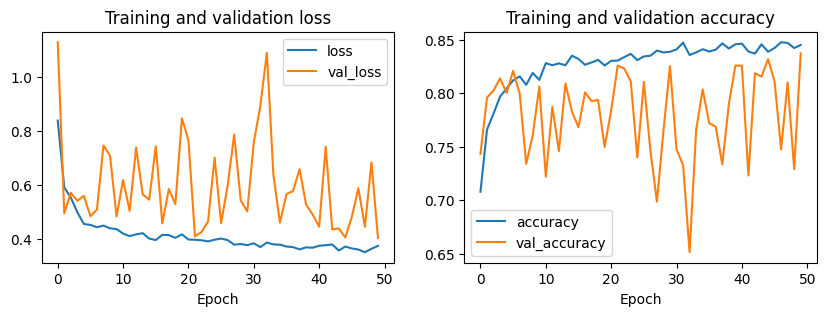

In [ ]:
plot_learning(history)

In [ ]:
model2.evaluate(resnet_test_xray)

87/87 [==============================] - 29s 299ms/step - loss: 0.3984 - accuracy: 0.8336


[0.3984028398990631, 0.8335745334625244]

#Resnet50 - Chest Xray Model

In [ ]:
model = resnet.output
model = resnet_data_augmentation(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = keras.Model(inputs= resnet.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
BATCH_SIZE = 64
EPOCHS = 25

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

checkpoint = ModelCheckpoint('Chest.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,checkpoint]

history = model.fit(resnet_train_xray,validation_data = resnet_valid_xray, epochs = EPOCHS,callbacks = callbacks,batch_size = BATCH_SIZE)
                     
                     

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8082
Epoch 1: val_loss improved from inf to 1.18329, saving model to Chest.keras
144/144 [==============================] - 130s 522ms/step - loss: 0.4689 - accuracy: 0.8082 - val_loss: 1.1833 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9016
Epoch 2: val_loss improved from 1.18329 to 0.45070, saving model to Chest.keras
144/144 [==============================] - 71s 470ms/step - loss: 0.2489 - accuracy: 0.9016 - val_loss: 0.4507 - val_accuracy: 0.8332 - lr: 1.0000e-04
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9631
Epoch 3: val_loss did not improve from 0.45070
144/144 [==============================] - 64s 433ms/step - loss: 0.1026 - accuracy: 0.9631 - val_loss: 0.5834 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 4/25
144/144 [==============================] - E

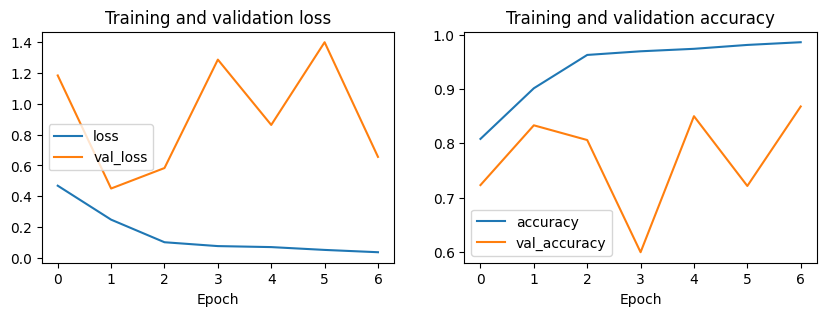

In [ ]:
plot_learning(history)

#Evaluation and Prediction

In [ ]:
model.evaluate(resnet_test_xray)

87/87 [==============================] - 28s 295ms/step - loss: 0.4199 - accuracy: 0.8455


[0.4198618233203888, 0.8455137610435486]

1/1 [==============================] - 1s 1s/step


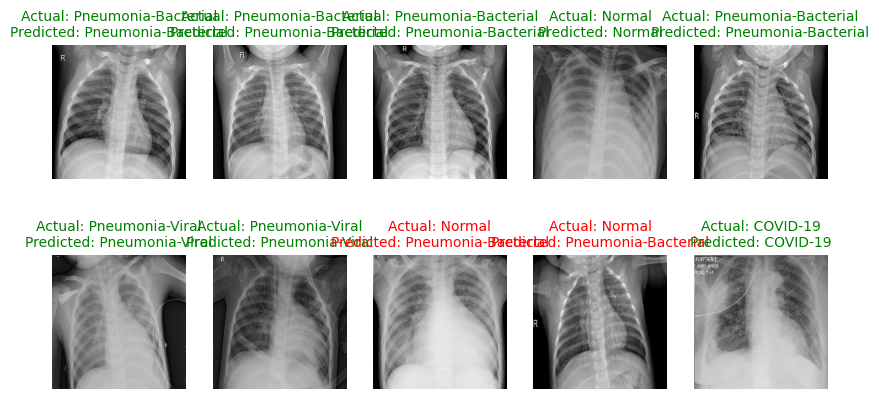

In [ ]:
display_predictions(model, resnet_test_xray, class_names)